This notebook will create non-overlapping polygons for each of five river reaches which I will be exploring in my analysis. 

In [1]:
#pip -q install earthaccess

In [2]:
#pip -q install distancerasters

In [3]:
# preliminaries
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily
import os
import io
import requests
import pandas as pd
import shapely
from osgeo import gdal
import rioxarray
import xarray
import earthaccess
import distancerasters as dr
from osgeo import gdal
from rasterio.enums import Resampling

# Identify river reaches associated with each point

First, load in point data associated with each river reach

In [4]:
sampling_points = gpd.read_file('data/nov_3s.geojson')
# only include site 1 for each location
sampling_points = sampling_points.loc[sampling_points.name.str.contains('1')]

Load hydrosheds data. Only include data within 40km of sampling points. 
These reaches are small. I belive they are associated with a stretch between
confluences but it may be worth it to aggragate between confluences of a certain
order.

In [5]:
# first create a bounding box of points 20km from sampling points
# re-project to appropriate UTM zone (EPSG:32648) https://epsg.io/32648
sampling_points_utm = sampling_points.to_crs('EPSG:32648')
bounds = sampling_points_utm.unary_union.convex_hull.buffer(40000)
bounds_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries( bounds), crs = sampling_points_utm.crs)

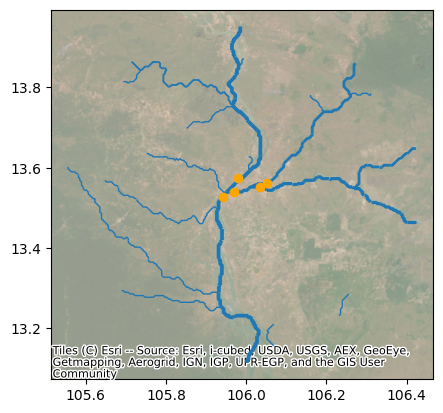

In [6]:
# download from https://www.hydrosheds.org/products/hydrorivers
hr_url = '/home/jovyan/data/HydroRIVERS_v10_as_shp'
rivers = gpd.read_file(hr_url, mask = bounds_gdf)
ax = rivers[rivers['ORD_STRA']>2].plot(linewidth=rivers[rivers['ORD_STRA']>2]['ORD_STRA']/3, zorder=10)
sampling_points.plot(ax=ax, color = "orange", zorder=20)
contextily.add_basemap(ax, 
                       crs=rivers.crs, 
                       source=contextily.providers.Esri.WorldImagery,
                      alpha = 0.5)

Identify which hydrosheds reaches are closest to each point. These may be used for 
initial analysis, but I would like to aggregate the reaches to include all reaches
between confluences. I will have to make a decision as to which confluences to include
(eg if a first-order stream flows in, will that mark a new reach, or will it only count
when higher-order streams flow in?)

In [7]:
# first reproject rivers to UTM 48
rivers_utm = rivers.to_crs(sampling_points_utm.crs)
# For each sampling point, find closest river reach, 
# ensuring that it matches with the large channel
sampling_points_merged_utm = sampling_points_utm.sjoin_nearest(rivers_utm.loc[rivers['ORD_STRA'] > 5, ['HYRIV_ID', 'geometry']], how='left')
sampling_points_merged_utm

,ele,time,name,geometry,index_right,HYRIV_ID
0,41.848339,2023-11-21 01:12:03+00:00,KSCS2-S1,POINT (606101.431 1500960.051),309,41338936
3,46.226585,2023-11-21 03:19:29+00:00,STS-1,POINT (602019.491 1495497.833),381,41340168
6,50.485073,2023-11-21 04:51:37+00:00,3SB-1,POINT (604961.861 1496949.311),332,41339305
9,44.720238,2023-11-21 08:39:23+00:00,SKG-1,POINT (613835.252 1499406.775),311,41338938
12,41.572842,2023-11-21 09:37:06+00:00,SSN-1,POINT (611893.715 1498311.861),327,41339237


In [8]:
reaches = rivers_utm.loc[sampling_points_merged_utm['index_right']]
reaches

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
309,41338936,41339304,41392598,1.94,664.1,4182.1,4.59,560079.6,0,9927.008,8,1,3,4121128230,"LINESTRING (606614.205 1500709.009, 605267.195..."
381,41340168,41341006,41392598,5.55,654.6,4191.5,22.12,639598.8,0,12891.121,8,1,2,4121128670,"LINESTRING (602572.750 1496545.269, 602123.621..."
332,41339305,41339382,41392598,6.25,660.6,561.4,11.48,79015.2,0,2940.137,7,2,3,4121128330,"LINESTRING (608879.798 1497953.045, 608430.797..."
311,41338938,41339074,41392598,10.36,669.7,543.8,35.68,28779.8,0,1076.272,6,3,3,4121128090,"LINESTRING (618317.608 1504906.781, 618321.748..."
327,41339237,41339158,41392598,4.45,668.0,554.1,7.51,50201.9,0,1860.881,7,2,3,4121128120,"LINESTRING (613841.598 1497513.052, 613388.720..."


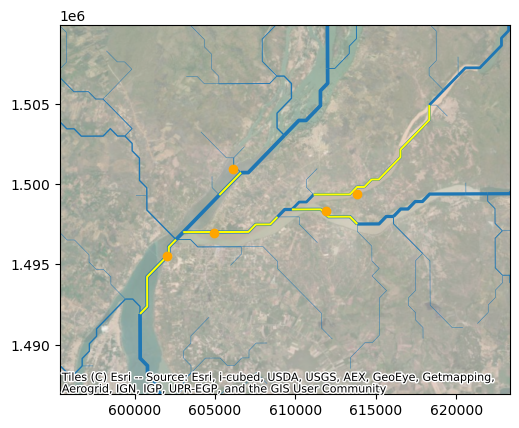

In [9]:
# visualize it
(xmin, ymin, xmax, ymax) = rivers_utm.loc[sampling_points_merged_utm['index_right']].unary_union.bounds
ax = rivers_utm.plot(linewidth=rivers['ORD_STRA']/3, zorder=1)
reaches.plot(ax=ax, color='yellow', zorder=10)
sampling_points_merged_utm.plot(ax=ax, color = "orange", zorder=20)
ax.set_xlim(xmin-5000, xmax+5000)
ax.set_ylim(ymin-5000, ymax+5000)
contextily.add_basemap(ax, 
                       crs=rivers_utm.crs.to_string(), 
                       source=contextily.providers.Esri.WorldImagery, 
                      alpha = 0.5)

# Create water polygon for each river reach 

For this, I will use the 
[JRC water classification dataset](https://global-surface-water.appspot.com/download). 

In [10]:
# Reproject water dataset into UTM 48N ('EPSG:32648')
dst_crs = 'EPSG:32648'
water_filename = '/home/jovyan/data/occurrence_100E_20Nv1_4_2021.tif'
proj_fn = os.path.splitext(water_filename)[0]+'_utm_gdalwarp.tif'
if not os.path.exists(proj_fn):
    !gdalwarp -r cubic -t_srs $dst_crs -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $water_filename $proj_fn
    

I'll load the water classification dataset into memory first, 
using rioxarray. 

Then, I'll load one image of HLS data so that I can project
the water classification dataset into the same CRS and resample
to match to ensure that my water masks match HLS data. 

## Load JRC water classification dataset

In [11]:
# open JRC wter classification dataset using rioxarray
water_xds = rioxarray.open_rasterio(water_filename, masked=True).squeeze()
water_xds

<xarray.DataArray (y: 40000, x: 40000)>
[1600000000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 100.0 100.0 100.0 100.0 ... 110.0 110.0 110.0 110.0
  * y            (y) float64 20.0 20.0 20.0 20.0 20.0 ... 10.0 10.0 10.0 10.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      value

In [12]:
water_xds.rio.transform()

Affine(0.00025, 0.0, 100.0,
       0.0, -0.00025, 20.0)

In [13]:
# Select only a window around the area I'm interested in
# don't use utm rivers because water ds is not in utm. 
window_bounds = rivers.unary_union.bounds
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
window = rio.windows.from_bounds(*window_bounds, transform=water_xds.rio.transform())
window

Window(col_off=22224.999999996857, row_off=24183.333333334216, width=3466.666666666919, height=3358.333333333292)

In [14]:
water_sel_xds = water_xds.rio.isel_window(window=window)
water_sel_xds

<xarray.DataArray (y: 3359, x: 3468)>
[11649012 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 105.6 105.6 105.6 105.6 ... 106.4 106.4 106.4 106.4
  * y            (y) float64 13.95 13.95 13.95 13.95 ... 13.12 13.12 13.11 13.11
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      value

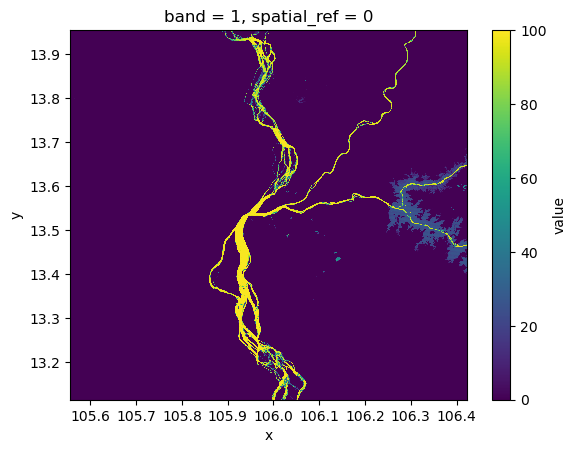

In [15]:
water_sel_xds.plot.imshow()

## Load HLS dataset over the same extent

Code for pulling this and saving to disc is in 00_data_downloads. 

In [16]:
hls_merged = rioxarray.open_rasterio('data/external/hls_region.nc').squeeze()

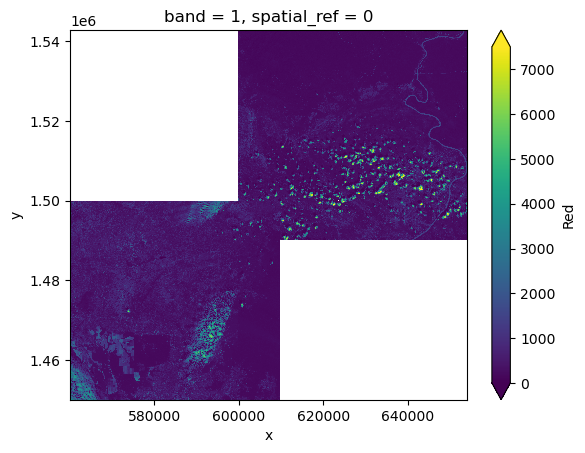

In [17]:
hls_merged.plot.imshow(vmin=0, vmax = 7500)

## Reproject water to match HLS

In [18]:
#Using nearest neighbor resampling
water_proj = water_sel_xds.rio.reproject_match(hls_merged)
water_proj

<xarray.DataArray (y: 3094, x: 3128)>
array([[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       ...,
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38]], dtype=float32)
Coordinates:
  * x            (x) float64 5.602e+05 5.602e+05 5.602e+05 ... 6.54e+05 6.54e+05
  * y            (y) float64 1.543e+06 1.543e+06 1.543e+06 ... 1.45e+06 1.45e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      value
    _FillValue:     3.402823466e+38

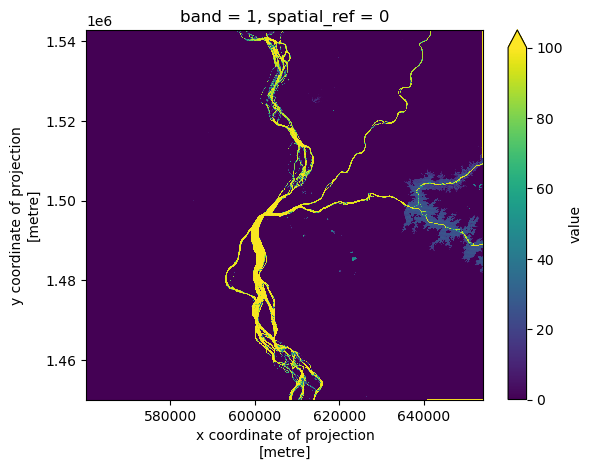

In [19]:
water_proj.plot.imshow(vmin=0,vmax=100, interpolation='none')

## Get water classification around water

Create a mask around each river vector

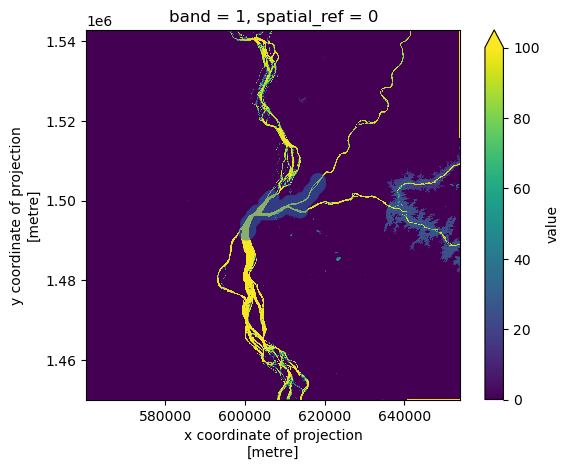

In [20]:
# create 2km mask around each river vector
buff = gpd.GeoDataFrame(geometry=gpd.GeoSeries(reaches['geometry'].buffer(2000).unary_union))
fig, ax = plt.subplots()
water_proj.plot.imshow(ax=ax, vmin=0,vmax=100, interpolation='none')
buff.plot(ax=ax, alpha = 0.5, zorder=100);

/srv/conda/envs/notebook/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


<xarray.DataArray (y: 566, x: 733)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 5.983e+05 5.984e+05 ... 6.203e+05 6.203e+05
  * y            (y) float64 1.507e+06 1.507e+06 1.507e+06 ... 1.49e+06 1.49e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      value

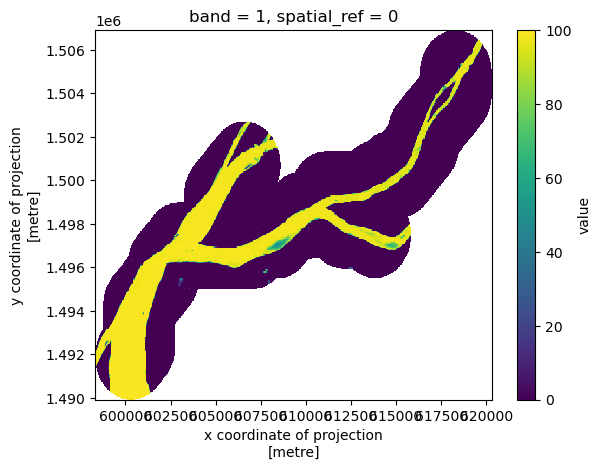

In [21]:
# clip water dataset to buffer
water_buff = water_proj.rio.clip(buff.geometry.values, drop=True)
water_buff = water_buff.where(water_buff != water_buff.rio.nodata)
water_buff.rio.write_nodata(water_buff.rio.nodata, encoded=True, inplace=True)
water_buff.plot.imshow(interpolation='none')
water_buff

# Determine threshold for water

So the algorithm for detecting water which this dataset comes from is not perfect, 
especially over water with high concentrations of sediments, which might reflect
more similarly to land. Upon closer inspection, it looks like I can't just use any 
portions of the water which are classified as water 100% of the time.

The tricky part is that there ARE parts of the river which are sometimes underwater 
and sometimes above water (this is mostly seasonal, depending on water level). 

You can see that there are lots of pixels which should be 100% water, but are classified 
as sometimes not underwater (more in the smaller tributaries).

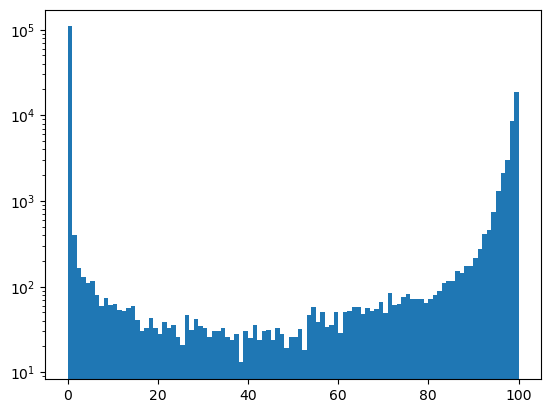

In [22]:
plt.hist(water_buff.values.ravel(), log=True, bins = 100);

Visual inspection for different water thresholds. 

It looks like 90 should preserve water while excluding islands. 

Another option would be to create a different mask for each year using 
HLS data. To do this, I would choose a cloud-free image from near the minimum
water level (luckily, this is easy to do because low water level occurs
when there are very few clouds). 

For now, I'll just use a threshold of 90. 

Text(0.5, 1.0, 'threshold: >80')

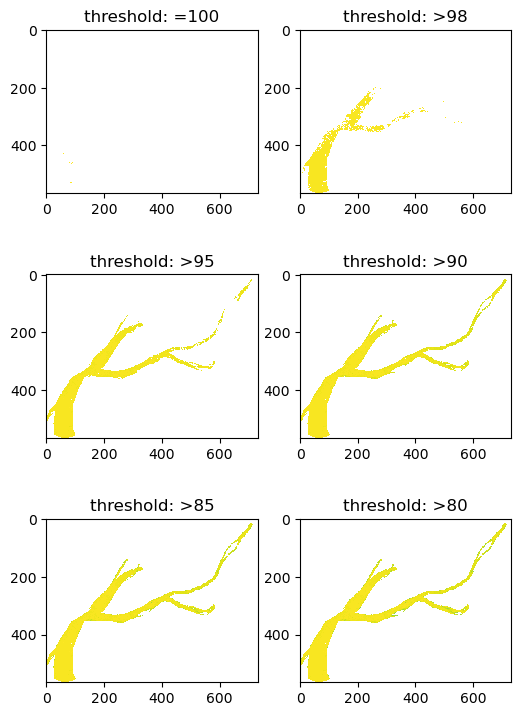

In [23]:
# identify pixels classified as water within the buffer
# first clip water raster to buffer
fig, ax = plt.subplots(3, 2, figsize=(6, 9))
ax[0,0].imshow(water_buff.where(water_buff > 99), interpolation='none', vmin=0, vmax=100)
ax[0,0].set_title('threshold: =100')
ax[0,1].imshow(water_buff.where(water_buff > 98), interpolation='none', vmin=0, vmax=100)
ax[0,1].set_title('threshold: >98')
ax[1,0].imshow(water_buff.where(water_buff > 95), interpolation='none', vmin=0, vmax=100)
ax[1,0].set_title('threshold: >95')
ax[1,1].imshow(water_buff.where(water_buff > 90), interpolation='none', vmin=0, vmax=100)
ax[1,1].set_title('threshold: >90')
ax[2,0].imshow(water_buff.where(water_buff > 85), interpolation='none', vmin=0, vmax=100)
ax[2,0].set_title('threshold: >85')
ax[2,1].imshow(water_buff.where(water_buff > 80), interpolation='none', vmin=0, vmax=100)
ax[2,1].set_title('threshold: >80')

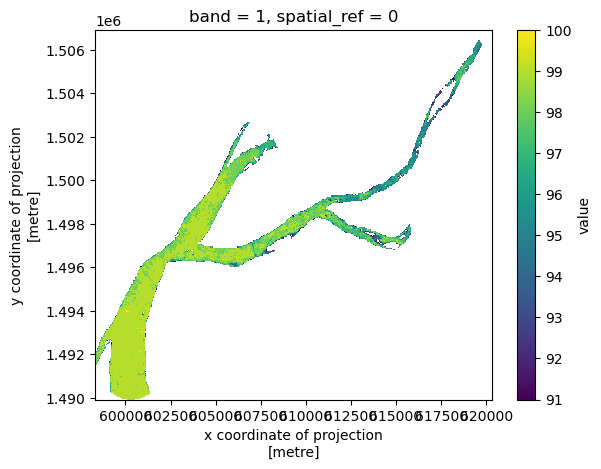

In [24]:
water_90 = water_buff.where(water_buff > 90)
water_90.plot.imshow()

## For each raster cell, calculate distance to each river reach

Use this package: https://github.com/sgoodm/python-distance-rasters

In [25]:
pwd

'/home/jovyan/github/lmb-metabolism-sensing'

In [26]:
# Save overall so I can read into xarray later
reach = reaches.geometry.values[0]
ar, tr = dr.rasterize(reaches, pixel_size=30, bounds=water_90.rio.bounds(), output="tmp/linestrings_rasterized_binary.tif")
def raster_conditional(rarray):
    return (rarray == 1)

In [27]:
distance = rioxarray.open_rasterio("tmp/linestrings_rasterized_binary.tif").squeeze()
distance.rio.write_crs(water_90.rio.crs, inplace=True)
distance = distance.to_dataset(name='reaches')

In [28]:
distance

<xarray.Dataset>
Dimensions:      (x: 734, y: 567)
Coordinates:
    band         int64 1
  * x            (x) float64 5.983e+05 5.984e+05 ... 6.203e+05 6.203e+05
  * y            (y) float64 1.507e+06 1.507e+06 1.507e+06 ... 1.49e+06 1.49e+06
    spatial_ref  int64 0
Data variables:
    reaches      (y, x) float64 ...

In [29]:
i=0
reach = reaches.geometry.values[0]
ar, tr = dr.rasterize(reach, pixel_size=30, bounds=water_90.rio.bounds())
r = dr.DistanceRaster(ar)

Tree build time: 0.0015 seconds
Distance calc run time: 11.6008 seconds


In [30]:
distance

<xarray.Dataset>
Dimensions:      (x: 734, y: 567)
Coordinates:
    band         int64 1
  * x            (x) float64 5.983e+05 5.984e+05 ... 6.203e+05 6.203e+05
  * y            (y) float64 1.507e+06 1.507e+06 1.507e+06 ... 1.49e+06 1.49e+06
    spatial_ref  int64 0
Data variables:
    reaches      (y, x) float64 ...

In [31]:
# This takes about a minute
for  i, reach in enumerate(reaches.geometry.values): 
    ar, tr = dr.rasterize(reach, pixel_size=30, bounds=water_90.rio.bounds())
    r = dr.DistanceRaster(ar)
    distance[i] = xarray.DataArray(xarray.DataArray(r.dist_array, dims=['y','x']))

Tree build time: 0.002 seconds
Distance calc run time: 11.5938 seconds
Tree build time: 0.0015 seconds
Distance calc run time: 11.6888 seconds
Tree build time: 0.0016 seconds
Distance calc run time: 11.585 seconds
Tree build time: 0.0016 seconds
Distance calc run time: 11.593 seconds
Tree build time: 0.0015 seconds
Distance calc run time: 11.6291 seconds


In [32]:
# Collapse distance datasets into a third dimension
distance_ar = distance[[0,1,2,3,4]].to_array()
# save to disc
# Actually dont: This takes SO MUCH MEMORY and will crash 
# distance_ar.to_netcdf(distance_fn)

In [33]:
distance_ar

<xarray.DataArray (variable: 5, y: 567, x: 734)>
array([[[341.53330731, 340.82546853, 340.11909679, ..., 499.87398412,
         500.78438474, 501.69512655],
        [340.82546853, 340.11909679, 339.41125497, ..., 499.46070917,
         500.37186172, 501.28335301],
        [340.11909679, 339.41125497, 338.70488629, ..., 499.04909578,
         499.96099848, 500.87323746],
        ...,
        [387.4041817 , 386.80873827, 386.21496605, ..., 578.33727184,
         579.12433898, 579.9120623 ],
        [388.20741879, 387.61320927, 387.02067128, ..., 578.95509325,
         579.74132163, 580.52820776],
        [389.01156795, 388.41858864, 387.82728114, ..., 579.57398147,
         580.35937142, 581.1454207 ]],

       [[373.25058607, 372.87665521, 372.50503352, ..., 683.97075961,
         684.83355642, 685.69672597],
        [372.32378382, 371.94892122, 371.57637169, ..., 683.46543439,
         684.32886831, 685.19267363],
        [371.39736133, 371.02156272, 370.64808107, ..., 682.96119948,
         683.82527008, 684.68971074],
...
        [528.03408981, 527.22765481, 526.42188404, ..., 382.37416231,
         382.81718875, 383.26231226],
        [528.62557638, 527.82004509, 527.01518005, ..., 383.27144428,
         383.71343474, 384.15751978],
        [529.21829145, 528.41366371, 527.60970423, ..., 384.16923354,
         384.61019227, 385.05324307]],

       [[474.605099  , 473.80270155, 473.00105708, ..., 375.8257575 ,
         376.43591752, 377.04774234],
        [474.00949358, 473.20608618, 472.40342928, ..., 375.03333185,
         375.64477901, 376.25789028],
        [473.41525113, 472.61083356, 471.807164  , ..., 374.24190038,
         374.85463849, 375.46904   ],
        ...,
        [473.41525113, 472.61083356, 471.807164  , ..., 329.84390248,
         330.49357029, 331.14498335],
        [474.00949358, 473.20608618, 472.40342928, ..., 330.6055051 ,
         331.25367922, 331.90360046],
        [474.605099  , 473.80270155, 473.00105708, ..., 331.36837508,
         332.0150599 , 332.66349364]]])
Coordinates:
    band         int64 1
  * x            (x) float64 5.983e+05 5.984e+05 ... 6.203e+05 6.203e+05
  * y            (y) float64 1.507e+06 1.507e+06 1.507e+06 ... 1.49e+06 1.49e+06
    spatial_ref  int64 0
  * variable     (variable) int64 0 1 2 3 4

In [34]:
# Get index of closest reach
closest_reach_idx = distance_ar.argmin(dim='variable')

In [35]:
# reproject to match water mask
closest_reach_idx = closest_reach_idx.rio.reproject_match(water_90, resampling=Resampling.nearest)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

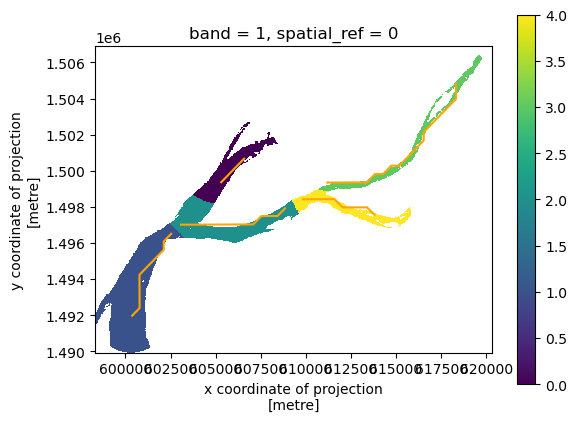

In [36]:
fig, ax = plt.subplots()
closest_reach_idx.where(water_90 > 0).plot.imshow(ax=ax)
reaches.plot(ax=ax, color = 'orange')

In [37]:
# Save it!
closest_reach_idx.to_netcdf('data/external/river_reach_mask.nc')